# Part 3.2. Building a model

In [6]:
from ipynb.fs.defs.p1_data_prep import load_dataset

In [30]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 

Load datasets for training and validation

In [8]:
x_train, y_train = load_dataset("./data/chest_xray/train/", 6000)
x_test, y_test = load_dataset("./data/chest_xray/test/", 6000)

Finished reading the dataset
Finished reading the dataset


(5216, 150, 150, 3)


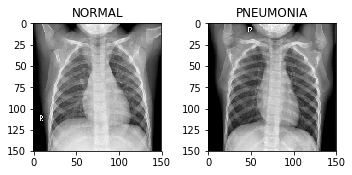

In [13]:
print(x_train.shape)

plt.figure(figsize=(5, 3))

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(x_train[np.argmax(y_train == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(x_train[np.argmax(y_train == 1)])

plt.tight_layout()

We're going to load VGG16 model with pre-trained ImageNet weights.

Next, we'll add a new classification layer composed of Flatten and Softmax layers.

In [60]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16

K.clear_session()

NUM_CLASSES = 2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

![](https://www.jeremyjordan.me/content/images/2018/04/vgg16.png)

In [61]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

We'll train only two bottom layers for now

In [62]:
for layer in model.layers[0:15]:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: True
layer 16: block5_conv2, trainable: True
layer 17: block5_conv3, trainable: True
layer 18: block5_pool, trainable: True
layer 19: flatten_1, trainable: True
layer 20: dense_1, trainable: True


In [63]:
optimizer_rmsprop = keras.optimizers.RMSprop(lr=0.0001)

model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer_rmsprop, 
              metrics=['accuracy'])

In [64]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

os.rmdir('./model')
os.makedirs('./model', exist_ok=True)

# This callback saves the wieights of the model after each epoch
checkpoint = ModelCheckpoint(
    'model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=False, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

In [65]:
from sklearn.utils import class_weight
y_labels = np.argmax(y_train, axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[1.9448173  0.67303226]


In [ ]:
history = model.fit(
    x=x_train, y=y_train,
    class_weight=classweight,
    validation_split=0.3,
    callbacks=[checkpoint, tensorboard],
    shuffle=True,
    batch_size=64,
    epochs=50,
    verbose=1
)

Train on 3651 samples, validate on 1565 samples
Epoch 1/50
3651/3651 [==============================] - 5s 1ms/step - loss: 10.0633 - acc: 0.3741 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00001: saving model to model/weights.epoch_01.hdf5
Epoch 2/50
3651/3651 [==============================] - 5s 1ms/step - loss: 10.1980 - acc: 0.3673 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00002: saving model to model/weights.epoch_02.hdf5
Epoch 3/50
3651/3651 [==============================] - 5s 1ms/step - loss: 10.1980 - acc: 0.3673 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00003: saving model to model/weights.epoch_03.hdf5
Epoch 4/50
3651/3651 [==============================] - 5s 1ms/step - loss: 10.1980 - acc: 0.3673 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00004: saving model to model/weights.epoch_04.hdf5
Epoch 5/50
3651/3651 [==============================] - 5s 1ms/step - loss: 10.1980 - acc: 0.3673 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: saving

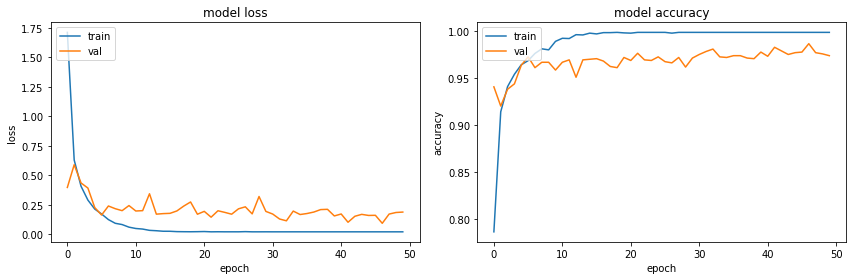

In [48]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

In [51]:
# restore the best model

idx = np.argmin(history.history['val_loss']) 
model.load_weights("model/weights.epoch_{02d}.hdf5".format(idx + 1))

print("Loading the best model - epoch: {}, val_loss: {}".format(idx + 1, history.history['val_loss'][idx]))

Best model - epoch: 47, val_loss: 0.09430696656408794


In [52]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 1.7411734626580533, Accuracy: 0.8349358974358975


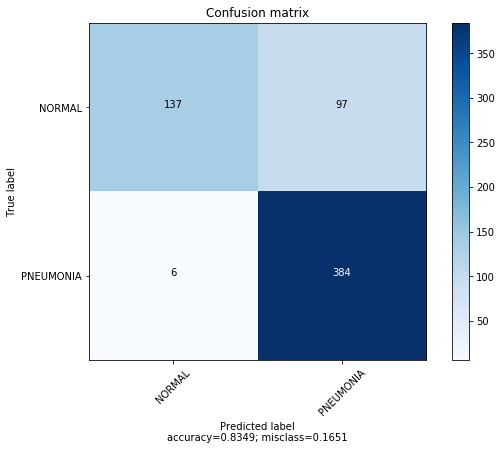

In [53]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)

Let's check the performance metrics when the test set is ballanced

(468, 67500)
(468,)
(468, 150, 150, 3)
(468, 2)


Text(0.5,1,'TEST (undersampled)')

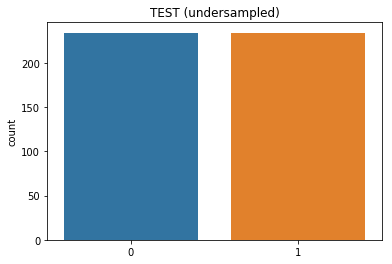

In [54]:
from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical

rus = RandomUnderSampler(random_state=42)

x_test_flat_shape = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]
x_test_flat = x_test.reshape(x_test.shape[0], x_test_flat_shape)

y_test_flat = np.argmax(y_test, axis=1)

x_res, y_res = rus.fit_resample(x_test_flat, y_test_flat)

print(x_res.shape)
print(y_res.shape)

y_test_rus = to_categorical(y_res, num_classes = 2)

for i in range(len(x_res)):
    height, width, channels = 150, 150, 3
    x_test_rus = x_res.reshape(len(x_res), height, width, channels)
    
print(x_test_rus.shape)
print(y_test_rus.shape)

sns.countplot(np.argmax(y_test_rus, axis=1)).set_title('TEST (undersampled)')

In [55]:
score = model.evaluate(x_test_rus, y_test_rus, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 2.273013615940605, Accuracy: 0.7841880341880342


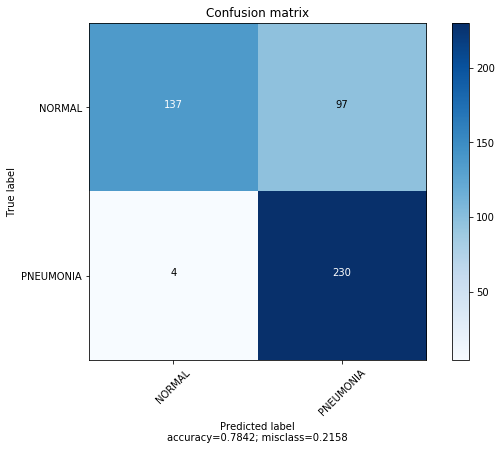

In [57]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model.predict(x_test_rus)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test_rus, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'], normalize=False)